In [1]:
# script to plot standard .las files
# most of the heavy lifting done with lasio and welly (github)


In [2]:
import welly
import lasio
import matplotlib.pyplot as plt
import numpy as np

In [60]:
ls

204-19-3A_logs.las*          205-21b-3_logs.las*
204-19-6.png                 LICENSE*
204-19-6_logs.las*           README.md*
204-19-7_logs.las*           [].png
204-20-1Z_logs.las*          foo.pdf
204-20-1_logs.las*           foo.svg
204-20-2_logs.las*           foo3.png
204-20-3_logs.las*           foo4.png
204-20-6A_logs.las*          foo5.png
204-20a-7_logs.las*          plotLAS.ipynb*
204-24a-6_logs.las*          plot_with_image.ipynb*
204-24a-7_logs.las*          sample_half_meter.jpeg*
204_19-6_DATACO_JWDL_QC.las* test.csv*
204_30-1_DATACO_JWDL_QC.las* {well_name}.png


In [97]:
datafile="204-20-2_logs.las" # want to loop over all *.las files in folder in the future

# depths that you want to plot from 
small = 2050
big = 2700

well_name = l.well.WELL.value # grab well name from header, needed for plotting later
savefile = well_name + '.png'

savefile=savefile.replace('/','-')


In [98]:


l = lasio.read(datafile)

z, gr, neutron, deepR = l['DEPTH'], l['GR'], l['NEUT'], l['RDEP'] # All wells will have this

selfp, microres, density, shalres, sp = l['SP'], l['RMIC'], l['DENS'], l['RSHAL'], l['SP']

# Don't pay attenton to the header error, these are fairly sparce headers (free UK gov .las)

Header section Parameter regexp=~P was not found.


In [99]:
# X = np.random.rand(50)

def get_top_bottom_depth(X, low, high):
    
    idxs = np.where(np.logical_and(X >= low, X <= high))[0]
    return idxs[0], idxs[-1]

itop, ibase = get_top_bottom_depth(z, small, big)

In [100]:
itop, ibase

(10827, 14370)

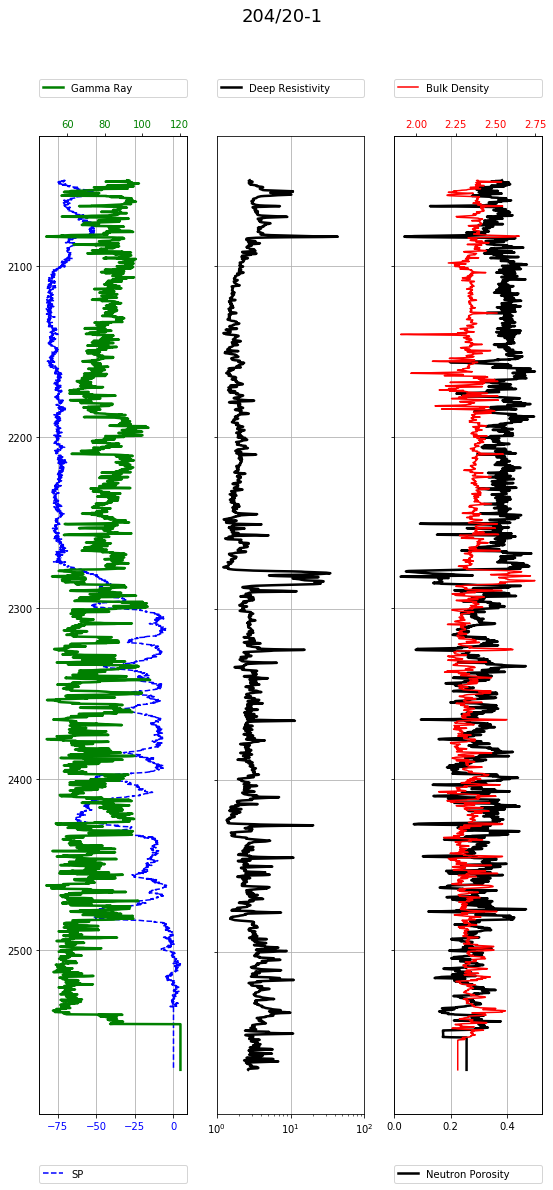

In [101]:
# Lets plot this bad boy
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,18))

# Gamma & SP
ax1.plot(sp[itop:ibase], z[itop:ibase], '--', lw=1.5, color='blue', label='SP')  # Spontaneous Potential
ax1.tick_params(axis='x', labelcolor='blue')
ax1.yaxis.label.set_size(100)
ax1.invert_yaxis()
ax1.grid(True)

# Lets do two axis ... one subplot
ax4 = ax1.twiny() # same y axis
ax4.plot(gr[itop:ibase], z[itop:ibase], lw=2.5, color='green', label='Gamma Ray') # Gamma Ray
ax4.tick_params(axis='x', labelcolor='Green')
ax4.yaxis.label.set_size(40)
# ax4.grid(True)

## subplot 1
ax1.legend( bbox_to_anchor=(0., -0.07, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax4.legend(bbox_to_anchor=(0., 1.04, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

# legend
ax1.legend( bbox_to_anchor=(0., -0.07, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax4.legend(bbox_to_anchor=(0., 1.04, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

# Resistivity
ax2.semilogx(deepR[itop:ibase],z[itop:ibase], lw=2.5, color='black', label='Deep Resistivity') # Deep Induction Resistivity
# ax2.semilogx(shalres[9000:11000], z[9000:11000],'-.', lw=1, color='black', label='RSHAL' ) # Spherically Focussed Log

ax2.legend(bbox_to_anchor=(0., 1.04, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax2.axes.yaxis.set_ticklabels([]) # get rid of y axis labels
ax2.set_xticks([1, 10, 100])
# ax2.axes.yaxis.set_ticklabels([.8, 8]) # get rid of y axis labels
ax2.invert_yaxis()
ax2.grid(True)


# Density and Porosity
ax3.plot(neutron[itop:ibase], z[itop:ibase], lw=2.5, color='black',label='Neutron Porosity') # Neutron Porosity
ax3.axes.yaxis.set_ticklabels([]) # get rid of y axis labels
ax3.invert_yaxis()
ax3.grid(True)

ax5 = ax3.twiny()
ax5.plot(density[itop:ibase], z[itop:ibase], lw=1.5, color='red', label='Bulk Density') # Bulk Density
ax5.tick_params(axis='x', labelcolor='red')
# ax5.grid(True)

# legend
ax3.legend( bbox_to_anchor=(0., -0.07, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax5.legend(bbox_to_anchor=(0., 1.04, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)



## overall 
plt.suptitle(well_name, fontsize=18) # well name title
plt.savefig(savefile, dpi=300) # save out to .png
#plt.savefig('foo3.svg', dpi=300) # save out to .svg
#plt.savefig('foo3.pdf', dpi=300) # save out to .svg

plt.show()

<bound method SubplotBase.label_outer of <matplotlib.axes._subplots.AxesSubplot object at 0x11808ceb8>>

plt.figure(figsize=(5,16))
plt.plot(gr, z, color='lightblue')
plt.plot(z, neutron, lw=3, color='red')
plt.plot(z, selfp, lw=1, color='black')
plt.show()

In [50]:
'get' + 'dog'

'getdog'